# Generative Adversarial Network(GAN)

###  Versions of packages
`python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
torch 1.10.0+cu111
torchvision 0.11.1+cu111


## Dataset

We use [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) from cuhk university. 

The images in this dataset cover large pose variations and background clutter. 

This dataset has large diversities, large quantities, and rich annotations, including:

- 10,177 number of identities,
- 202,599 number of face images, and
- 5 landmark locations, 40 binary attributes annotations per image.
- Original Size: 218x178

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir data
!unzip -qq -n ./drive/MyDrive/celeba_dataset.zip -d data/celeba

### Load Data

In [4]:
import torch
import torch.utils.data as data
from torchvision import transforms, datasets

In [5]:
def get_celeba(root, split, download=False):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('./data', 'train',)
    dataset_test = get_celeba('./data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

train 162770
test 19962


In [6]:
batch_size = 32
img_size = 64
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             drop_last=True)

Let's sample some images and plot them.

In [35]:
import matplotlib.pyplot as plt

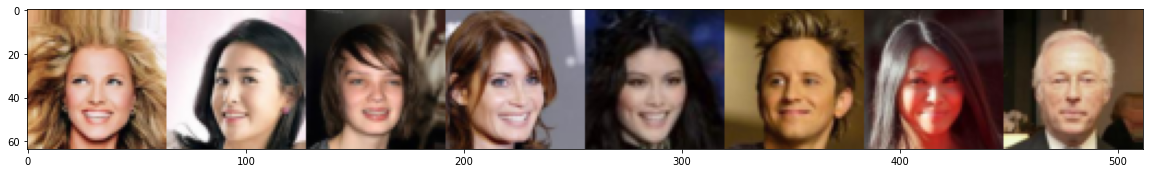

In [36]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, img_size, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    if save_file:
        plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

## Build Model


In [65]:
import torch
import math
from torch import nn
import torch.nn.functional as F

latent_dim = 100
g_hidden = 128 # hidden dim of generator (Imitate real data)
d_hidden = 128 # hidden dim of discriminator (Identify authenticity)

class Generator(nn.Module): # Generate simulation data

    def __init__(self):
        super().__init__()

        # add activation
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8, kernel_size=4, stride=1, padding=0, bias=False),

            nn.BatchNorm2d(g_hidden*8),
            nn.ReLU(True),
            # nn.SELU(True),
            # --> some regularization and activation
            # shape is (g_hidden*8, 4, 4),

            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            
            nn.BatchNorm2d(g_hidden * 4),
            nn.ReLU(True),
            # --> some regularization and activation
            # shape is (g_hidden*4, 8, 8),

            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            
            nn.BatchNorm2d(g_hidden * 2),
            nn.ReLU(True),
            # --> some regularization and activation
            # shape is (g_hidden*2, 16, 16),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            
            nn.BatchNorm2d(g_hidden),
            nn.ReLU(True),
            # --> some regularization and activation
            # shape is (g_hidden, 32, 32),

            nn.ConvTranspose2d(g_hidden, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # shape is (3, 64, 64),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # add activation
        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            # nn.BatchNorm2d(d_h idden),
            nn.LeakyReLU(0.2, inplace=True),
            # --> some regularization and activation
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            nn.BatchNorm2d(d_hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # --> some regularization and activation
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            nn.BatchNorm2d(d_hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # --> some regularization and activation
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.SELU(True),
            nn.BatchNorm2d(d_hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # --> some regularization and activation
            # shape is (d_hidden * 8, 4, 4),

            nn.Conv2d(d_hidden * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # nn.Sigmoid(),
            # shape is (1, 1, 1)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__

    # ---------- You Should Modify ----------
    # TODO: correct weight initialization
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        # torch.nn.init.normal_(m.weight, 0.0, 0.5/math.sqrt(m.weight.numel()))
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        # torch.nn.init.normal_(m.weight, 0.0, 1.0/math.sqrt(m.weight.size()[1]))
        torch.nn.init.zeros_(m.bias)

### Test Model


In [66]:
def test_model():
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print('生成:', out.shape)
    out2 = net_d(out)
    print('識別:', out2.shape)
test_model()

生成: torch.Size([16, 3, 64, 64])
識別: torch.Size([16])


In [67]:
# Hyper-Parameter setting
lr = 2e-4
beta1 = 0.5
start_epoch = 1
max_epoch = 3
dataset = train_data

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [68]:
device = torch.device('cuda')

net_g = Generator().to(device)
net_g.apply(weights_init) # apply weight init

net_d = Discriminator().to(device)
net_d.apply(weights_init) # apply weight init

criterion = nn.BCEWithLogitsLoss()

optim_d = torch.optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.99))

In [69]:
print(net_d.apply(weights_init))
print(net_g.apply(weights_init))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
Generator(
  (main): Sequential(
    (0): Con

Make some fixed noise.  
To see evolutions of our generator model.  
And labels filled with 0 and 1 for training.

In [70]:
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

### Training Loop

Training section of DCGAN can be split into two update stage and three parts.

**First**, we feed discirminator some true images and label 1.

**Second**, discriminator is trained with fake images generated by generator model and label 0. Then, we do one discriminator optimizer step.

**Third**, we will make generator make some fake images and throw them into discriminator with true label 1 try to fool the discriminator.

Finally, generator optimizer update once. 


[1/3 - 0/5086] Loss_D: 0.8186 Loss_G: 11.9071


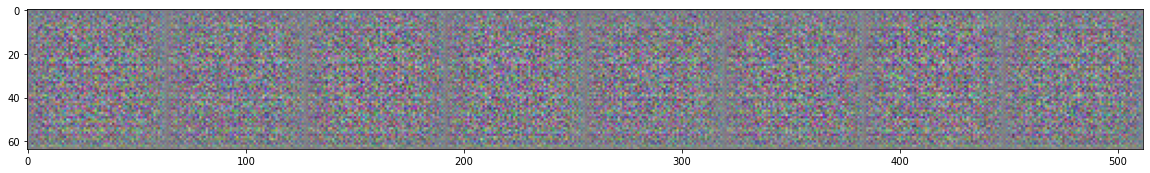

[1/3 - 1017/5086] Loss_D: 0.9673 Loss_G: 6.1692


<Figure size 432x288 with 0 Axes>

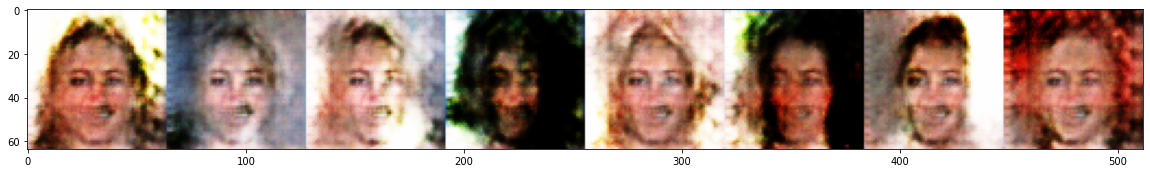

[1/3 - 2034/5086] Loss_D: 0.1660 Loss_G: 2.8998


<Figure size 432x288 with 0 Axes>

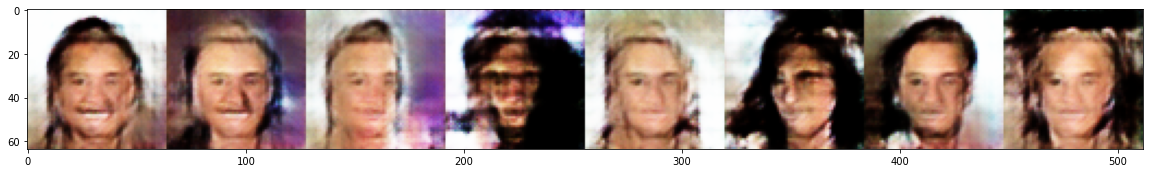

[1/3 - 3051/5086] Loss_D: 0.1106 Loss_G: 2.8745


<Figure size 432x288 with 0 Axes>

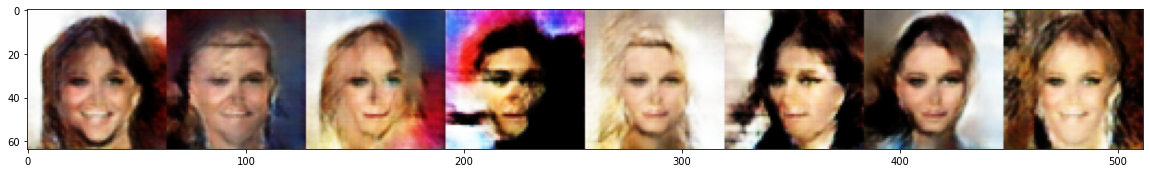

[1/3 - 4068/5086] Loss_D: 0.2561 Loss_G: 1.4997


<Figure size 432x288 with 0 Axes>

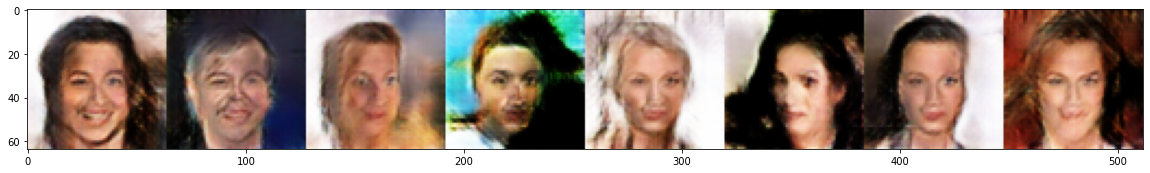

[1/3 - 5085/5086] Loss_D: 0.0805 Loss_G: 1.2083


<Figure size 432x288 with 0 Axes>

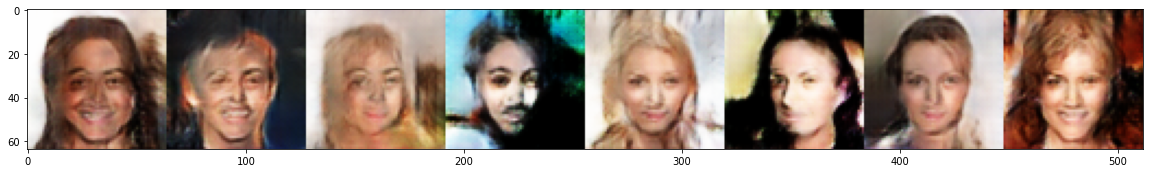

------------------------------
[2/3 - 0/5086] Loss_D: 1.3872 Loss_G: 5.6166


<Figure size 432x288 with 0 Axes>

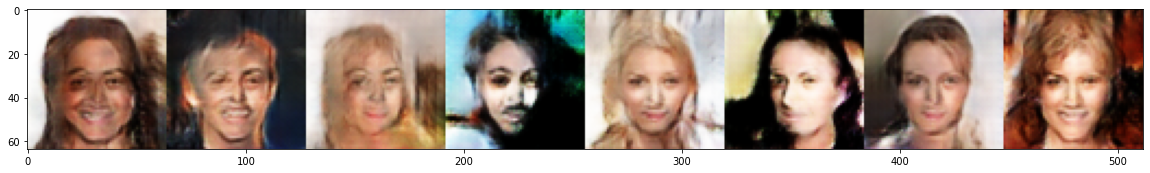

[2/3 - 1017/5086] Loss_D: 0.2223 Loss_G: 3.0925


<Figure size 432x288 with 0 Axes>

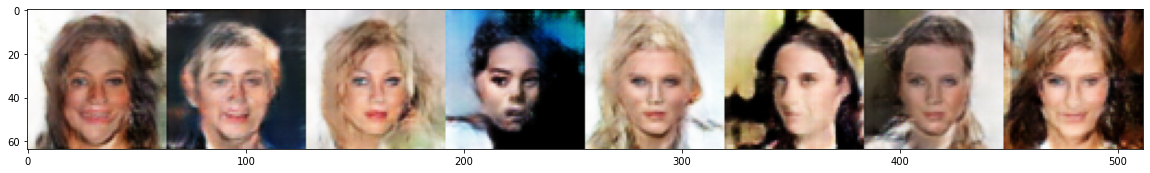

[2/3 - 2034/5086] Loss_D: 1.0993 Loss_G: 5.9736


<Figure size 432x288 with 0 Axes>

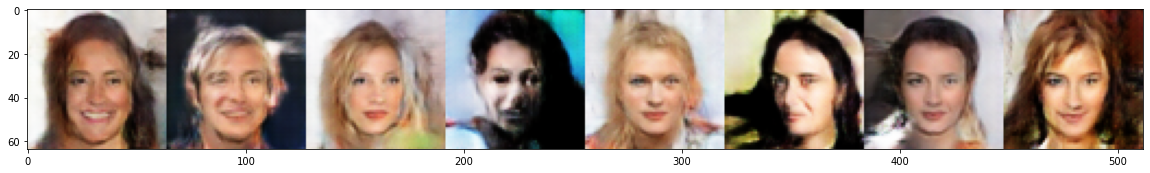

[2/3 - 3051/5086] Loss_D: 0.3164 Loss_G: 3.4069


<Figure size 432x288 with 0 Axes>

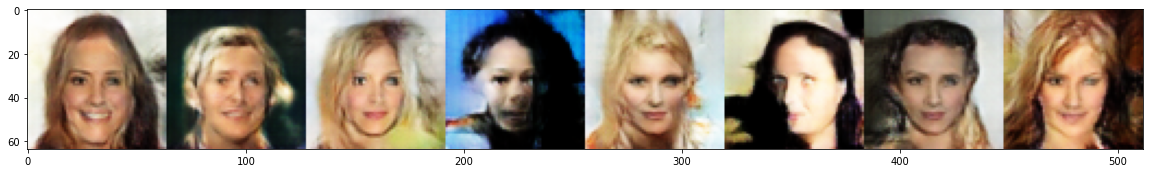

[2/3 - 4068/5086] Loss_D: 0.1512 Loss_G: 1.4927


<Figure size 432x288 with 0 Axes>

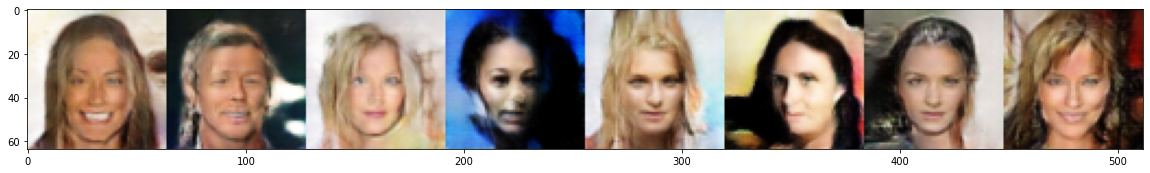

[2/3 - 5085/5086] Loss_D: 0.7150 Loss_G: 6.4165


<Figure size 432x288 with 0 Axes>

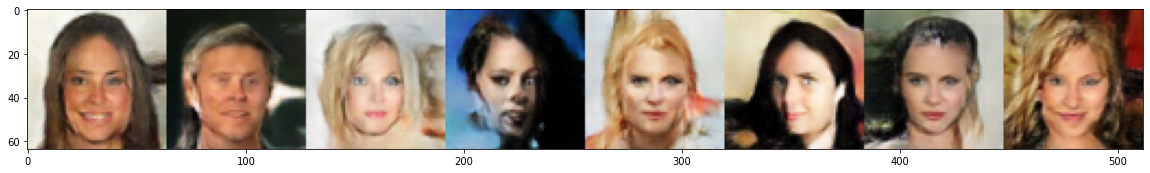

------------------------------
[3/3 - 0/5086] Loss_D: 0.0303 Loss_G: 2.4804


<Figure size 432x288 with 0 Axes>

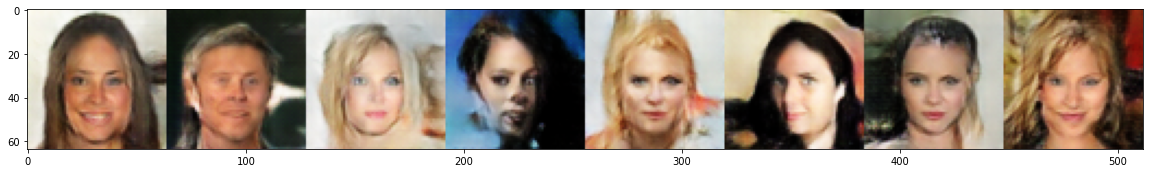

[3/3 - 1017/5086] Loss_D: 0.8962 Loss_G: 6.9265


<Figure size 432x288 with 0 Axes>

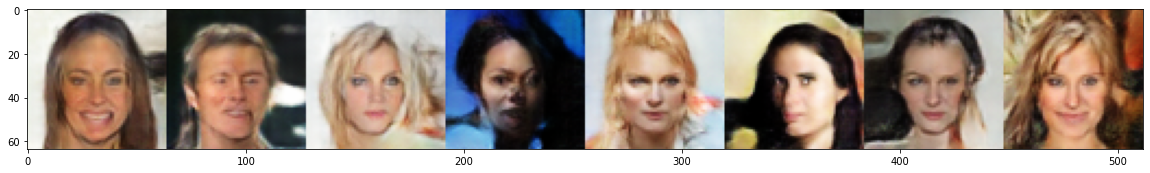

In [ ]:
from tqdm import tqdm
import time

log_step = int(len(dataset) * 0.2)
t = time.time()

for epoch in range(start_epoch, max_epoch + 1):
    loader = enumerate(dataset)
    d_loss_list = []
    g_loss_list = []
    for i, (imgs, _) in loader:
        loss_temp = {
            'err_d': [],
            'err_g': []
        }
        imgs = imgs.to(device)
              


        # ========== Update Discriminator ==========

        for p in net_d.parameters():
          p.requires_grad = True

        net_d.zero_grad()
        # throw real image into discirminator
        real_output = net_d(imgs)
        real_loss = criterion(real_output, real_label)
        real_loss.backward()

        # generate fake image and throw into discirminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        fake_output = net_d(fake_imgs.detach())

        # calculate loss
        err_d = criterion(fake_output, fake_label)
        err_d.backward()
        loss_temp['err_d'].append(err_d.item())
        optim_d.step()
        
        # ========== Update Generator ==========
        
        for p in net_d.parameters():  
          p.requires_grad = False
        net_g.zero_grad()

        output = net_d(fake_imgs)


        err_g = criterion(output, real_label)
        err_g.backward()
        loss_temp['err_g'].append(err_g.item())
        optim_g.step()
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format( # y_d: {:.4f} / {:.4f}
                epoch, max_epoch, i, len(dataset),
                err_d.item(), err_g.item(),# y_d_real, y_d_fake#, y_g_real, y_g_fake
            ))

            fix_fake_imgs = net_g(fixed_noise).cpu().detach()
            plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
    
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    d_loss_list.append(l_d)
    g_loss_list.append(l_g)
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')